# Imports

In [69]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as st #new library
import random #new library
import folium #new library
from simple_colors import * #new library
from pathlib import Path
import json

# Relevant imports for Flights Section
from skyscanner_request import skyscanner_api  # connects to the 'skyscanner_request.py' function file

# Relevant imports for Hotels section
from booking_locations_request import booking_locations_api # connects to the booking_locations_request.py" function file
from booking_hotels_request import booking_hotels_api # connects to the booking_locations_request.py" function file

# Client Data

In [22]:
# Generate required variables to run APIs

departure_date = "2021-12-01"
return_date = "2021-12-15"
market_country = "US" # country where client is currently present

# Set input variables for skyscanner API request

departure_airport = "LAX"
destination_airport = "JFK"
locale_skyscanner = "en-US"
currency = "USD"

# Set input variables for BOOKING.COM API request
destination_city = "New York"
locale_booking = "en-us"
nr_rooms = 1
nr_adults = 1

# SKYSCANNER API Request

In [4]:
# Make an API request from skyscanner

flight_response = skyscanner_api(
    market_country, 
    departure_date, 
    return_date, 
    departure_airport, 
    destination_airport, 
    locale_skyscanner, 
    currency
)

flight_response

{'Quotes': [{'QuoteId': 1,
   'MinPrice': 104,
   'Direct': False,
   'OutboundLeg': {'CarrierIds': [851],
    'OriginId': 65368,
    'DestinationId': 60987,
    'DepartureDate': '2021-12-01T00:00:00'},
   'QuoteDateTime': '2021-10-25T14:13:00'},
  {'QuoteId': 2,
   'MinPrice': 148,
   'Direct': True,
   'OutboundLeg': {'CarrierIds': [870],
    'OriginId': 65368,
    'DestinationId': 60987,
    'DepartureDate': '2021-12-01T00:00:00'},
   'QuoteDateTime': '2021-10-25T15:03:00'}],
 'Carriers': [{'CarrierId': 851, 'Name': 'Alaska Airlines'},
  {'CarrierId': 870, 'Name': 'jetBlue'}],
 'Places': [{'Name': 'New York John F. Kennedy',
   'Type': 'Station',
   'PlaceId': 60987,
   'IataCode': 'JFK',
   'SkyscannerCode': 'JFK',
   'CityName': 'New York',
   'CityId': 'NYCA',
   'CountryName': 'United States'},
  {'Name': 'Los Angeles International',
   'Type': 'Station',
   'PlaceId': 65368,
   'IataCode': 'LAX',
   'SkyscannerCode': 'LAX',
   'CityName': 'Los Angeles',
   'CityId': 'LAXA',
   

In [23]:
# Extract values for itinerary into variables

# Create loop that stores all quotes provided by the API

for quote in range(len(flight_response['Quotes'])):

    if quote == 0:  # If there's only one quote, everything below will be stored in a variable

        flight_price = [flight_response['Quotes'][quote]['MinPrice']]
        airline = [flight_response['Carriers'][quote]['Name']]
        departure_date_time = flight_response['Quotes'][quote]['OutboundLeg']['DepartureDate']
        departure_airport = flight_response['Places'][0]['Name']
        departure_airport_code = flight_response['Places'][0]['IataCode']
        arrival_airport = flight_response['Places'][1]['Name']
        arrival_airport_code = flight_response['Places'][1]['IataCode']
        if flight_response['Quotes'][quote]['Direct'] == True:
            layover = ["Direct flight"]
        elif flight_response['Quotes'][quote]['Direct'] != True:
            layover = ["Flight with layover(s)"]

    else: # If there is more than one quote, the new flights and airlines will be appended to their respective variables
        new_flight = flight_response['Quotes'][quote]['MinPrice']
        new_airline = flight_response['Carriers'][quote]['Name']
        flight_price.append(new_flight)
        airline.append(new_airline)

        if flight_response['Quotes'][quote]['Direct'] == True:
            new_layover = "Direct flight"
            layover.append(new_layover)
        elif flight_response['Quotes'][quote]['Direct'] != True:
            new_layover = "Flight with layover(s)"
            layover.append(new_layover)


In [24]:
# Create dataframe of quotes

quotes_list = flight_response['Quotes']
flight_quotes_df = pd.json_normalize(quotes_list).set_index('QuoteId') #json_normalize creates extra columns for the nested fields

flight_quotes_df

,MinPrice,Direct,QuoteDateTime,OutboundLeg.CarrierIds,OutboundLeg.OriginId,OutboundLeg.DestinationId,OutboundLeg.DepartureDate
QuoteId,,,,,,,
1,104,False,2021-10-25T14:13:00,[851],65368,60987,2021-12-01T00:00:00
2,148,True,2021-10-25T15:03:00,[870],65368,60987,2021-12-01T00:00:00


In [25]:
# Replace the CarrierIds by the Carrier Name on flight_quotes_df
# This code goes through every quote and can handle quotes that have more than one carrier

# Create dataframe of carriers (contains carrier id and name)
carriers_df = pd.DataFrame(flight_response['Carriers']).set_index('CarrierId')


# Create loop that will replace the Carrier Ids with Carrier Names

carriers_row = []
carriers = []

for row in range(len(flight_quotes_df['OutboundLeg.CarrierIds'])):

    # List all carriers for each quote
    quote_carriers = flight_quotes_df['OutboundLeg.CarrierIds'].iloc[row]
    
    # For the row in question: for each carrier, append the Carrier name to a list of carriers in the row
    for carrier in range(len(quote_carriers)):
        carrier_id = quote_carriers[carrier]
        carrier_name = carriers_df.loc[carrier_id]['Name']
        carriers_row.append(carrier_name)
        
    # Store the carriers in each row for all rows
    carriers.append(carriers_row)
    carriers_row = []

# Replace the carrier IDs for carrier names in the flight_quotes_df
flight_quotes_df['OutboundLeg.CarrierIds'] = carriers
flight_quotes_df


,MinPrice,Direct,QuoteDateTime,OutboundLeg.CarrierIds,OutboundLeg.OriginId,OutboundLeg.DestinationId,OutboundLeg.DepartureDate
QuoteId,,,,,,,
1,104,False,2021-10-25T14:13:00,[Alaska Airlines],65368,60987,2021-12-01T00:00:00
2,148,True,2021-10-25T15:03:00,[jetBlue],65368,60987,2021-12-01T00:00:00


In [26]:
# Make changes to dataframe

# Rename columns on dataframe
flight_quotes_df.rename(columns={'MinPrice': 'Flight Cost', 'OutboundLeg.CarrierIds': 'Carriers'}, inplace=True)


# Create loop that transforms the list of carriers for each row into a string

rows =[]
for item in range(len(flight_quotes_df['Carriers'])):
    row_values = flight_quotes_df['Carriers'].iloc[item]
    row_as_string = " ".join(map(str,row_values)) #this turns the list [] into a string with all elements
    rows.append(row_as_string)

flight_quotes_df['Carriers'] = rows
flight_quotes_df

,Flight Cost,Direct,QuoteDateTime,Carriers,OutboundLeg.OriginId,OutboundLeg.DestinationId,OutboundLeg.DepartureDate
QuoteId,,,,,,,
1,104,False,2021-10-25T14:13:00,Alaska Airlines,65368,60987,2021-12-01T00:00:00
2,148,True,2021-10-25T15:03:00,jetBlue,65368,60987,2021-12-01T00:00:00


In [27]:
# Plot a comparison of the quotes

flight_quotes_plot = px.bar(flight_quotes_df, 
    x='Carriers', 
    y='Flight Cost',
    title = f"{departure_airport_code} to {arrival_airport_code} Flight Quotes",
    color_discrete_sequence =['orange']*len(flight_quotes_df),
)


flight_quotes_plot.update_layout(
    yaxis_title="Flight Cost (USD)",
    hover_datae="Price"
)

flight_quotes_plot

In [28]:
# Print itinerary quote(s)

if len(flight_response['Quotes']) == 1:  # if there's only one quote, the message below is printed

    print(f"Here's the cheapest flight information we have found:")
    print(f"----------------------------------------------------------")
    print(f"-{layover[quote]}-")
    print(f"{airline} for ${flight_price}, leaving on {departure_date}")
    print(f"Departing from {departure_airport}, {departure_airport_code}")
    print(f"Arriving at {arrival_airport}, {arrival_airport_code}")

elif len(flight_response['Quotes']) > 1: # if there's more than one quote, all options are printed
    
    print(f"Here are some flight options we have found:")
    print(f"----------------------------------------------------------")

    for quote in range(len(flight_response['Quotes'])):
        print(f"Option {quote + 1 }:")
        print(f"-{layover[quote]}-")
        print(f"{airline[quote]} for ${flight_price[quote]}, leaving on {departure_date}")
        print(f"Departing from {departure_airport}, {departure_airport_code}")
        print(f"Arriving at {arrival_airport}, {arrival_airport_code}")
        print(f" ")


Here are some flight options we have found:
----------------------------------------------------------
Option 1:
-Flight with layover(s)-
Alaska Airlines for $104, leaving on 2021-12-01
Departing from New York John F. Kennedy, JFK
Arriving at Los Angeles International, LAX
 
Option 2:
-Direct flight-
jetBlue for $148, leaving on 2021-12-01
Departing from New York John F. Kennedy, JFK
Arriving at Los Angeles International, LAX
 


In [29]:
# Export the flight quotes to a text file that contains the final results

# Set output file name
output_path = 'flights_output.txt'

# Open the output path as a file object
with open(output_path, 'w') as file:
    if len(flight_response['Quotes']) == 1:  # if there's only one quote, the message below is printed

        file.write(f"Here's the cheapest flight information we have found:\n")
        file.write(f"----------------------------------------------------------\n")
        file.write(f"-{layover[quote]}-\n")
        file.write(f"{airline} for ${flight_price}, leaving on {departure_date}\n")
        file.write(f"Departing from {departure_airport}, {departure_airport_code}\n")
        file.write(f"Arriving at {arrival_airport}, {arrival_airport_code}\n")

    elif len(flight_response['Quotes']) > 1: # if there's more than one quote, all options are printed
    
        file.write(f"Here are some flight options we have found:\n")
        file.write(f"----------------------------------------------------------\n")

        for quote in range(len(flight_response['Quotes'])):
            file.write(f"Option {quote + 1 }:\n")
            file.write(f"-{layover[quote]}-\n")
            file.write(f"{airline[quote]} for ${flight_price[quote]}, leaving on {departure_date}\n")
            file.write(f"Departing from {departure_airport}, {departure_airport_code}\n")
            file.write(f"Arriving at {arrival_airport}, {arrival_airport_code}\n")
            file.write(f" \n")


# BOOKING.COM API Requests

In [57]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")

In [61]:
# Make API request from Booking.com for number of hotels in the city by location (districts, landmarks, areas, etc.)
location_endpoint_response = booking_locations_api(destination_city, locale_booking)

In [62]:
# Make changes to the dataframe
locations_df = pd.DataFrame.from_dict(location_endpoint_response).set_index('dest_id')
locations_df.drop(columns = ['country', 'city_ufi', 'landmark_type', 'region','rtl', 'timezone', 'lc', 'cc1', 'image_url', 'hotels', 'type'], inplace =True)
locations_df

,name,label,latitude,dest_type,longitude,city_name,nr_hotels
dest_id,,,,,,,
20088325,New York,"New York, New York State, United States",40.768074,city,-73.981895,New York,1382
929,Manhattan,"Manhattan, New York, New York State, United St...",40.776115,district,-73.970891,New York,638
1174,Times Square,"Times Square, New York, New York State, United...",40.756727,district,-73.987197,New York,88
20085207,Brooklyn,"Brooklyn, New York State, United States",40.696086,city,-73.984507,Brooklyn,496
2306,Central New York City,"Central New York City, New York, New York Stat...",40.759591,district,-73.984912,New York,252


In [63]:
# Set the mapbox access token
px.set_mapbox_access_token(map_box_api)

# Create a scatter mapbox to analyze neighborhood info
locations_map_plot = px.scatter_mapbox(
    locations_df,
    lat="latitude",
    lon="longitude",
    width=1000, 
    height=1000,
    opacity=0.9,
    color = locations_df['dest_type'],
    size = locations_df['nr_hotels'],
    hover_name = locations_df['name'],
    hover_data = {'name':True, 'dest_type': True, 'nr_hotels':True, 'longitude': False, 'latitude': False, 'city_name': False},
    zoom = 10
)

locations_map_plot.show()

In [65]:
# Make API request from Booking.com for hotels in a specific dest_id (districts, landmarks, areas, etc.)


# Select a random dest_id from the locations_df
list_dest_ids = locations_df.index.values.tolist()
random_dest_id = random.choice(list_dest_ids)
dest_type = locations_df.loc[random_dest_id]['dest_type']

# Run API request
hotels_endpoint_response = booking_hotels_api(dest_type, departure_date, return_date, nr_rooms, locale_booking, random_dest_id, nr_adults)



In [66]:
random_dest_id

'20088325'

In [67]:
# Generate dataframe with hotel results

hotels_df = pd.DataFrame.from_dict(hotels_endpoint_response["result"])

# Filter out desired columns from dataframe
desired_cols = ["hotel_id","hotel_name","min_total_price","distance_to_cc", "district","address","zip","review_score_word","review_score","checkout","latitude","longitude","urgency_message","url"]
hotels_df = hotels_df[hotels_df.columns.intersection(desired_cols)]

# Organize dataframe columns, sort by price(lowest to highest) and set index to hotel_id
hotels_df = hotels_df.reindex(columns=desired_cols).set_index('hotel_id').sort_values('min_total_price')
#hotels_df['min_total_price'] = hotels_df['min_total_price'].map('${:,.2f}'.format)
hotels_df.head(5)

,hotel_name,min_total_price,distance_to_cc,district,address,zip,review_score_word,review_score,checkout,latitude,longitude,urgency_message,url
hotel_id,,,,,,,,,,,,,
1106729,West Side YMCA,1371.200000,0.35,Upper West Side,5 West 63rd Street,NY 10023,Good,7.3,"{'until': '11:00', 'from': ''}",40.770845,-73.980612,NaN,https://www.booking.com/hotel/us/west-side-ymc...
183147,Pod 51,2486.324425,1.75,Midtown East,230 East 51st Street,NY 10022,Very Good,8.0,"{'until': '12:00', 'from': ''}",40.755910,-73.969078,NaN,https://www.booking.com/hotel/us/pod.html
2377260,Pod Times Square,2729.766550,1.45,Hell's Kitchen,400 West 42nd Street,NY 10036,Very Good,8.5,"{'from': '', 'until': '12:00'}",40.758395,-73.993099,NaN,https://www.booking.com/hotel/us/pod-times-squ...
56276,"The New Yorker, A Wyndham Hotel",2754.690250,2.00,Hell's Kitchen,481 Eighth Avenue,NY 10001,Good,7.8,"{'until': '12:00', 'from': ''}",40.752628,-73.993352,NaN,https://www.booking.com/hotel/us/new-yorker-ra...
6162805,TBA Times Square,3225.418700,1.60,Hell's Kitchen,340 West 40th Street,NY 10018,Good,7.4,"{'until': '11:00', 'from': '11:00'}",40.756511,-73.992690,NaN,https://www.booking.com/hotel/us/tba-times-squ...


In [68]:
hotel_pricing_plot = px.scatter(
    hotels_df,
    x= hotels_df['min_total_price'],
    y = hotels_df['review_score'],
    color = hotels_df['district'],
    size = hotels_df['min_total_price'], 
    labels=dict(review_score="Review Scores", district="District", min_total_price = "Price in USD for entire stay"),
    title="Hotel Pricing and Reviews by District" 
)

hotel_pricing_plot.update_traces(hovertemplate ='<b>Price</b>: $%{x:.2f} <br> <b>Score</b>: %{y}')

hotel_pricing_plot

95% of the hotels are within a price range of : (3772.012427388473, 5119.805140111525)


<AxesSubplot:ylabel='Frequency'>

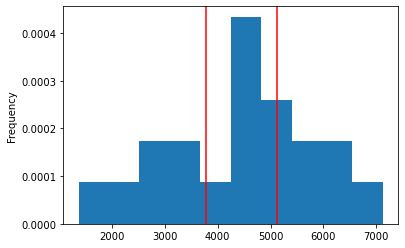

In [87]:
# Calculate 95% confidence interval

#Calculate the sample parameters
confidenceLevel = 0.95   # 95% CI given
degrees_freedom = len(hotels_df['min_total_price'])-1  #degree of freedom = sample size-1
sampleMean = np.mean(hotels_df['min_total_price'])    #sample mean
sampleStandardError = st.sem(hotels_df['min_total_price'])  #sample standard error

#create 95% confidence interval for the population mean
confidenceInterval = st.t.interval(alpha=confidenceLevel, df=degrees_freedom, loc=sampleMean, scale=sampleStandardError)

#print the 95% confidence interval for the population mean
print(f"95% of the hotels are within a price range of : {confidenceInterval}")

# plot

hotels_95_interval = hotels_df['min_total_price'].plot(kind='hist', bins=10,density=True)
hotels_95_interval .axvline(confidenceInterval[0], color='r')
hotels_95_interval .axvline(confidenceInterval[1], color='r')
hotels_95_interval

In [50]:
# Use folium to create Map of hotels in dest_id of choice (district, landmark, city, etc.)

# Creates map around a set of coordinates from the dataframe
start_coords = [hotels_df['latitude'].iloc[0], hotels_df['longitude'].iloc[0]]
m = folium.Map(location=start_coords, zoom_start=12)


# Create loop that adds all hotel coordinates to the map
coords = [hotels_df['latitude'].to_list(), hotels_df['longitude'].to_list()]

for i in range(len(coords[0])):
    folium.Marker(location= [coords[0][i], coords[1][i]],
    tooltip= hotels_df['hotel_name'].iloc[i],
    icon=folium.Icon(icon='bed', prefix='fa'),
    popup =f"{hotels_df['review_score'].iloc[i]}/10"
    ).add_to(m) 
 
hotels_map = m
hotels_map

# icon examples for hotels: "bed" "h-square" these two need the prefix 'fa' for font awesome website (recommended by folium documentation)

In [54]:
# Save map
hotels_map.save('hotels_map.html')

In [55]:
# Print hotel quotes

print(f"Here are some hotel options for you:")
print(f"----------------------------------------------------------")

for quote in range(len(hotels_df)):
    print(green(f"{hotels_df['hotel_name'].iloc[quote]}"), f"({hotels_df['review_score'].iloc[quote]}/10.0)")
    print(f"{hotels_df['address'].iloc[quote]} {hotels_df['zip'].iloc[quote]}")
    print(f"Price: ${hotels_df['min_total_price'].iloc[quote]:.2f}")
    print(blue(f"{hotels_df['url'].iloc[quote]}"))

    #this loop checks if there is an urgency_message for the hotel, if present, it prints the message
    if type(hotels_df['urgency_message'].iloc[quote])==str:
        print(f"{hotels_df['urgency_message'].iloc[quote]}")
    elif type(hotels_df['urgency_message'].iloc[quote])==float:
        pass

    print(f" ")

Here are some hotel options for you:
----------------------------------------------------------
West Side YMCA (7.3/10.0)
5 West 63rd Street NY 10023
Price: $1231.20
https://www.booking.com/hotel/us/west-side-ymca.html
 
Pod Times Square (8.5/10.0)
400 West 42nd Street NY 10036
Price: $2196.18
https://www.booking.com/hotel/us/pod-times-square.html
 
The New Yorker, A Wyndham Hotel (7.8/10.0)
481 Eighth Avenue NY 10001 
Price: $2308.50
https://www.booking.com/hotel/us/new-yorker-ramada-plaza.html
 
Holiday Inn Manhattan Financial District, an IHG Hotel (8.1/10.0)
99 Washington Street NY 10006
Price: $3057.48
https://www.booking.com/hotel/us/holiday-inn-financial-district.html
 
Hotel Edison Times Square (7.7/10.0)
228 West 47th Street NY 10036
Price: $3249.00
https://www.booking.com/hotel/us/edison-triumph-group.html
 
Hotel Hayden New York (8.0/10.0)
127 West 28th Street NY 10001
Price: $3460.80
https://www.booking.com/hotel/us/hayden.html
 
Ameritania at Times Square (8.2/10.0)
230 We

In [56]:
# Export the analysis to a text file that contains the final results

# Set output file name
output_path = 'hotels_output.txt'

# Open the output path as a file object
with open(output_path, 'w') as file:
    file.write(f"Here are some hotel options for you:\n")
    file.write(f"----------------------------------------------------------\n")

    for quote in range(len(hotels_df)):
        file.write(f"{hotels_df['hotel_name'].iloc[quote]}\n") 
        file.write(f"{hotels_df['review_score'].iloc[quote]}/10.0)\n")
        file.write(f"{hotels_df['address'].iloc[quote]} {hotels_df['zip'].iloc[quote]}\n")
        file.write(f"Price: ${hotels_df['min_total_price'].iloc[quote]:.2f}\n")
        file.write(f"{hotels_df['url'].iloc[quote]}\n")

        #this loop checks if there is an urgency_message for the hotel, if present, it prints the message
        if type(hotels_df['urgency_message'].iloc[quote])==str:
            file.write(f"{hotels_df['urgency_message'].iloc[quote]}\n")
        elif type(hotels_df['urgency_message'].iloc[quote])==float:
            pass

        file.write(f" \n")